In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import sys
sys.path.append("./cresi/src")


env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

W0907 20:12:45.134038 140125683918656 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W0907 20:12:45.174942 140125683918656 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [3]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
mumbai = data_dir/"AOI_8_Mumbai"
ms_mumbai = mumbai/"MS"
ps_rgb_mumbai = mumbai/"PS-RGB"

In [55]:
from utils import create_small_tiles, scale_percentile

In [52]:
mask_folder = mumbai / "masks"

mask_512_folder = mumbai /"masks_512"
mask_512_folder.mkdir(exist_ok=True)

rgb_512_folder = mumbai /"rgb_512"
rgb_512_folder.mkdir(exist_ok=True)

img_fnames = ps_rgb_mumbai.ls()
img_ids = [x.name.replace('.tif', '').split('_')[-1] for x in img_fnames]
mask_fnames =[ mask_folder / f"{img_id}.png" for img_id in img_ids]



In [66]:
valid_imgs = list(set([x.name.split('_')[2].replace('.jpg', '') for x in rgb_512_fold.ls()]))
np.random.seed(42)
mumbai_ids = np.array(valid_imgs)
np.random.shuffle(mumbai_ids)
np.random.seed(None)

In [69]:
len(valid_imgs), len(mumbai_ids)

(641, 641)

#### Training Tile creation

only create tiles for images with roads, and only save tiles with stretches of road on them

In [57]:
task_fn = partial(create_small_tiles,save_dir_rgb=rgb_512_fold,save_dir_mask=mask_512_folder)
%time _= Parallel(n_jobs=16)(delayed(task_fn)(img_filepath,mask_filepath,im_id) for (img_filepath,mask_filepath,im_id) in zip(img_fnames, mask_fnames, img_ids))

# %time _= [create_small_tiles( img_filepath,mask_filepath,im_id,rgb_512_fold,mask_512_folder,new_img_height=512) for  (img_filepath,mask_filepath,im_id) in zip(img_fnames, mask_fnames, img_ids)]

CPU times: user 1.45 s, sys: 276 ms, total: 1.73 s
Wall time: 1min 56s


#### modelling round1

In [70]:
train_ids = mumbai_ids[:int(0.8*len(mumbai_ids))]
valid_ids = mumbai_ids[int(0.8*len(mumbai_ids)):]

print(len(train_ids), len(valid_ids))

512 129


In [75]:
def get_mask_fn(fname):
    return mask_512_folder / fname.name.replace("rgb", "mask").replace("jpg", "png")


def is_valid_image(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in mumbai_ids

def is_in_validation_set(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in valid_ids

codes = np.array(["void", "road"])

src = (SegmentationItemList.from_folder(rgb_512_folder)
       .filter_by_func(is_valid_image)
       .split_by_valid_func(is_in_validation_set)
       .label_from_func(get_mask_fn, classes=codes)
      )

bs = 16
size=512

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

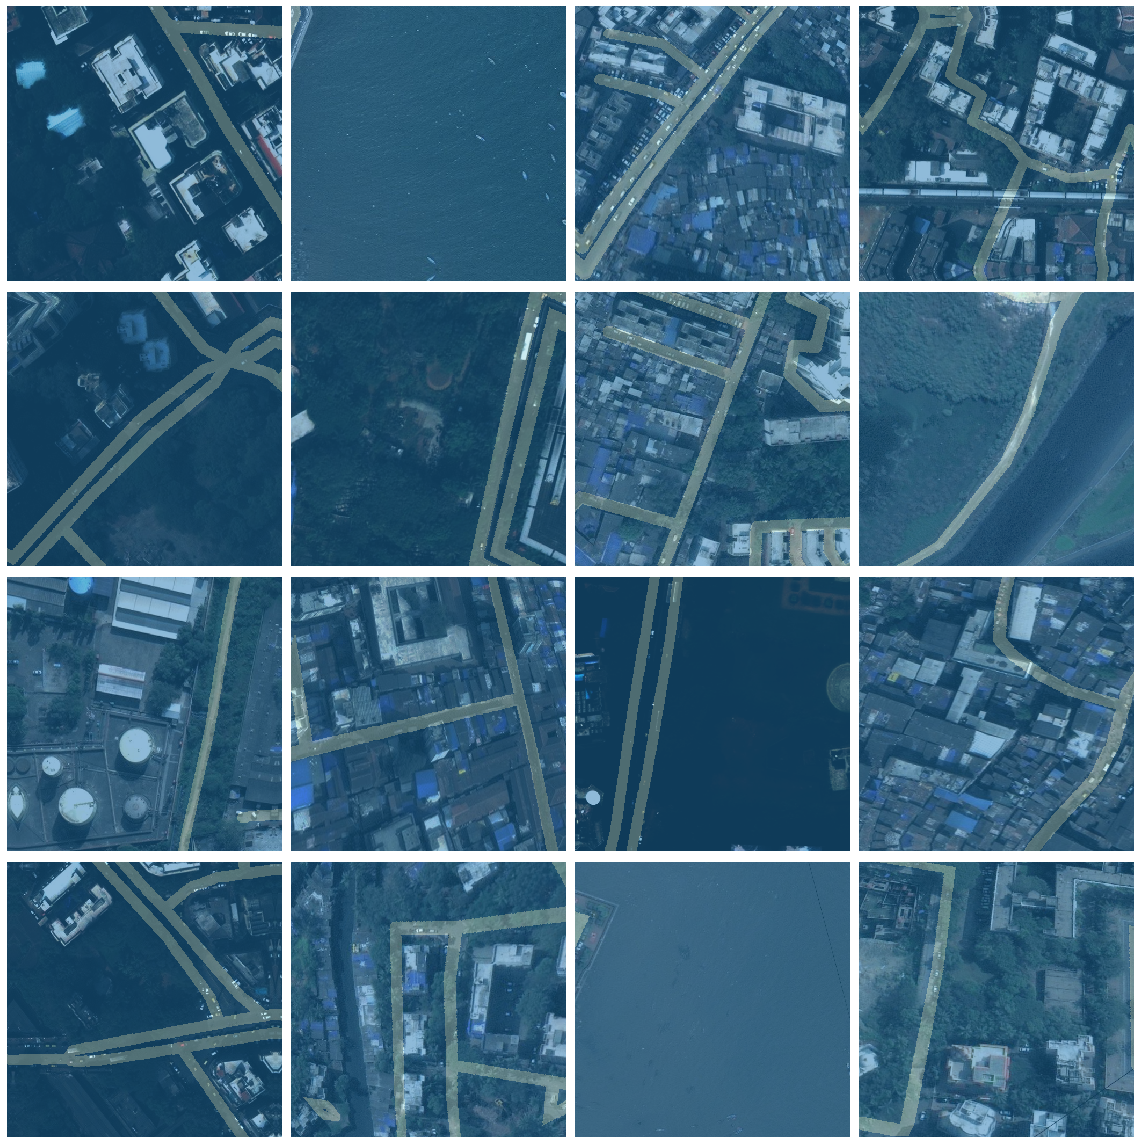

In [76]:
data.show_batch()

In [ ]:
tfms = get_transforms(
    do_flip=True, 
    flip_vert=True,
    max_rotate=90, max_zoom=1.1, max_lighting:float=0.2, max_warp:float=0.2, 
    p_affine=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)




return Compose([
        RandomFlip(0.5),
        Transpose(0.5),
        RandomShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=30, prob=.75),
        Jitter_HSV()
    ])